In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [5]:
df1 = pd.read_excel('data/X_bp.xlsx',index_col=0)
df2 = pd.read_excel('data/X_nup.xlsx',index_col=0)

In [6]:
# Объединение файлов по индексу, тип объединения — INNER.
X_full=pd.merge(df1, df2, left_index=True, right_index=True, how='inner')

In [8]:
# Разделение на признаки (X) и целевую переменную (Y)
X = X_full.drop(columns=['Соотношение матрица-наполнитель'])  # Замените 'Target' на имя вашей целевой переменной
Y = X_full['Соотношение матрица-наполнитель']

C:\Users\Kirill Shumkin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.3400 - mean_absolute_error: 0.7268 - val_loss: 0.1973 - val_mean_absolute_error: 0.5994 - learning_rate: 5.0000e-04
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2799 - mean_absolute_error: 0.6661 - val_loss: 0.2194 - val_mean_absolute_error: 0.6401 - learning_rate: 5.0000e-04
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2512 - mean_absolute_error: 0.6300 - val_loss: 0.2256 - val_mean_absolute_error: 0.6512 - learning_rate: 5.0000e-04
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2561 - mean_absolute_error: 0.6489 - val_loss: 0.2260 - val_mean_absolute_error: 0.6519 - learning_rate: 5.0000e-04
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2353 - mean_absolute_error: 0.6227 - val_loss: 0.2254 - val_mean_absolute_error: 0.6510 - learning_rate: 5.0000e-04
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2062 - mean_absolute_error: 0.5791 - val_loss: 0.2236

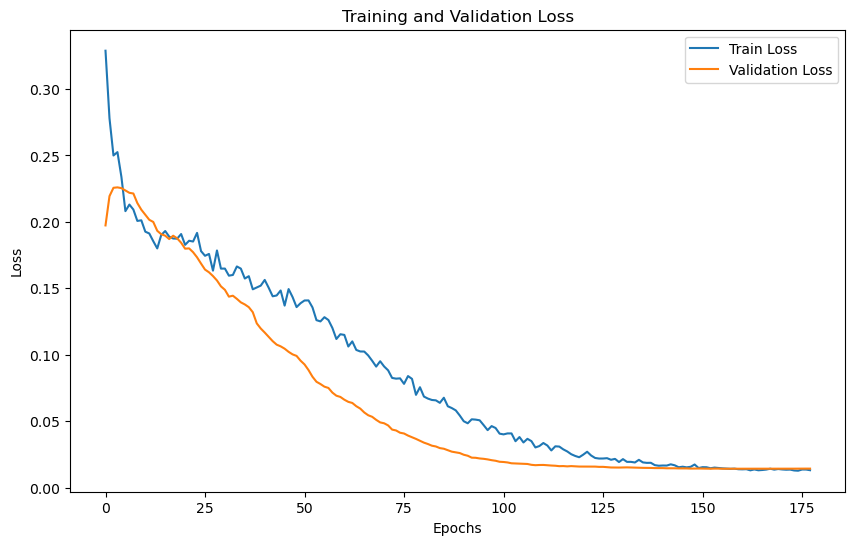

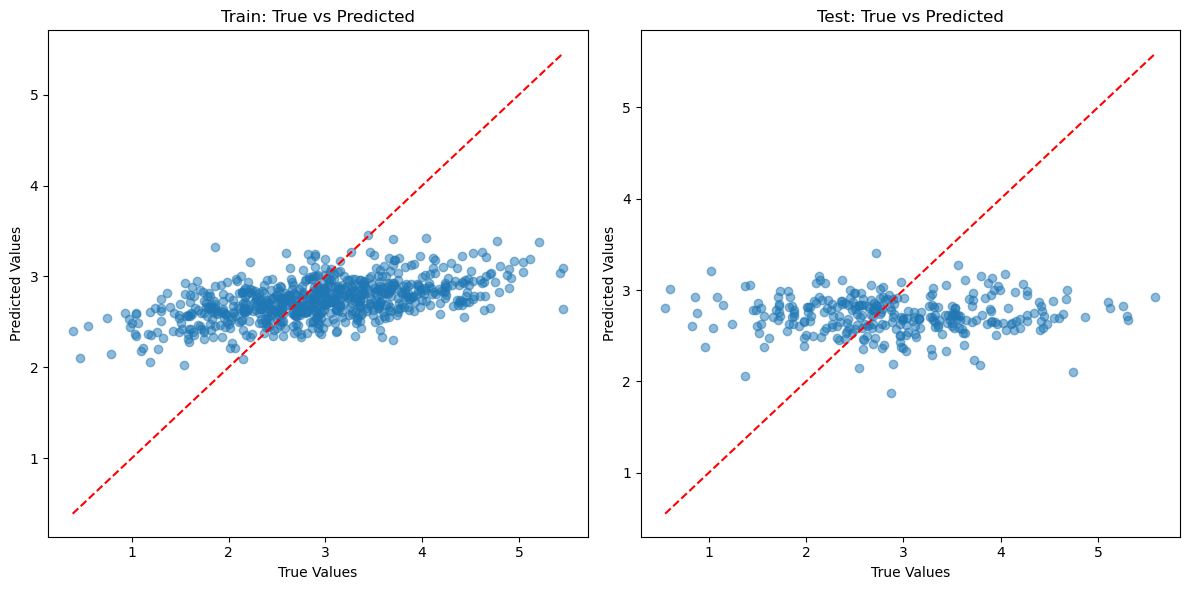

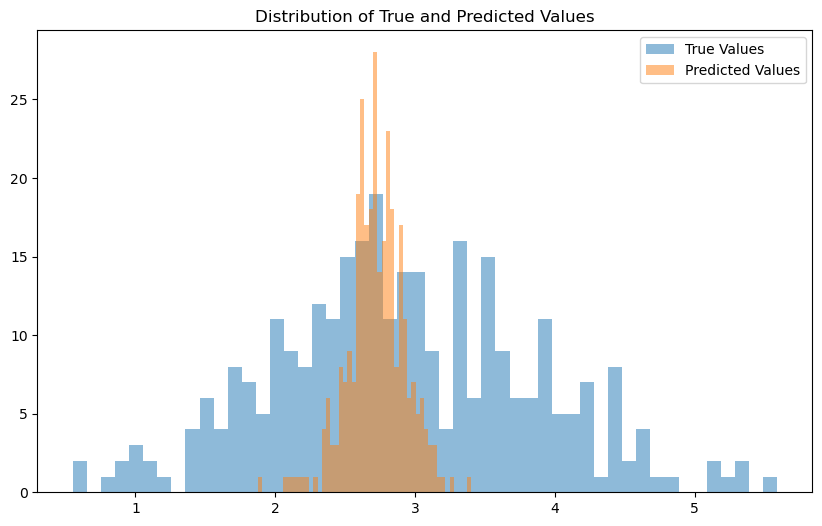

In [9]:
# Преобразуем Y в логарифмический масштаб
Y_log = np.log1p(Y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.3, random_state=24)

# Стандартизация признаков и нормализация целевой переменной
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = MinMaxScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_scaled = scaler_y.transform(Y_test.values.reshape(-1, 1))

# Построение нейронной сети
model = Sequential()

# Входной слой
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Скрытые слои
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Выходной слой
model.add(Dense(1, activation='relu'))

# Компиляция модели
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mean_absolute_error'])

# Callbacks для оптимизации
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

# Обучение модели
history = model.fit(X_train_scaled, Y_train_scaled, 
                    epochs=300, batch_size=32, 
                    validation_data=(X_test_scaled, Y_test_scaled), 
                    callbacks=[early_stopping, lr_scheduler], verbose=1)

# Предсказания
Y_pred_train_scaled = model.predict(X_train_scaled)
Y_pred_test_scaled = model.predict(X_test_scaled)

# Обратное масштабирование и обратное логарифмирование
Y_pred_train = np.expm1(scaler_y.inverse_transform(Y_pred_train_scaled))
Y_pred_test = np.expm1(scaler_y.inverse_transform(Y_pred_test_scaled))

Y_train_orig = np.expm1(Y_train)
Y_test_orig = np.expm1(Y_test)

# Вычисление метрик
mse_train = mean_squared_error(Y_train_orig, Y_pred_train)
r2_train = r2_score(Y_train_orig, Y_pred_train)
mae_train = mean_absolute_error(Y_train_orig, Y_pred_train)

mse_test = mean_squared_error(Y_test_orig, Y_pred_test)
r2_test = r2_score(Y_test_orig, Y_pred_test)
mae_test = mean_absolute_error(Y_test_orig, Y_pred_test)

# Вывод метрик
print(f"Train MSE: {mse_train}")
print(f"Train R²: {r2_train}")
print(f"Train MAE: {mae_train}")
print(f"Test MSE: {mse_test}")
print(f"Test R²: {r2_test}")
print(f"Test MAE: {mae_test}")

# Визуализация обучения
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Визуализация предсказаний vs истинные значения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_train_orig, Y_pred_train, alpha=0.5)
plt.plot([min(Y_train_orig), max(Y_train_orig)], [min(Y_train_orig), max(Y_train_orig)], color='red', linestyle='--')
plt.title("Train: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.subplot(1, 2, 2)
plt.scatter(Y_test_orig, Y_pred_test, alpha=0.5)
plt.plot([min(Y_test_orig), max(Y_test_orig)], [min(Y_test_orig), max(Y_test_orig)], color='red', linestyle='--')
plt.title("Test: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

# Гистограммы распределения
plt.figure(figsize=(10, 6))
plt.hist(Y_test_orig, bins=50, alpha=0.5, label='True Values')
plt.hist(Y_pred_test, bins=50, alpha=0.5, label='Predicted Values')
plt.title('Distribution of True and Predicted Values')
plt.legend()
plt.show()